# Example of FA and OCTA image registration

This document shows a basic example of the use of the implemented method to register Fluorescein angiography (FA) and Optical Coherence Tomography Angiography (OCTA) images. The FA image represents a global image of the eye, while the OCTA image represents only a local region. For this reason, the FA image will be used as **fixed** and the OCTA as the image to be transformed (**moving**).

The document includes:
1. A brief introduction to the parameters required.
2. An example using a OCTA 3x3mm image.
3. An example using a OCTA 6x6mm image.
4. Same example as in [3] but sped up.

---

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('../src/'))

import data_reader
import registration
import plots

In [2]:
DISPLAY_SIZE = 6.8  # Size of images displayed in the document
DATASET_IMAGES = "../dataset/FA_OCTA/images/"
dataset = data_reader.Dataset(DATASET_IMAGES)

Load an example case from dataset.

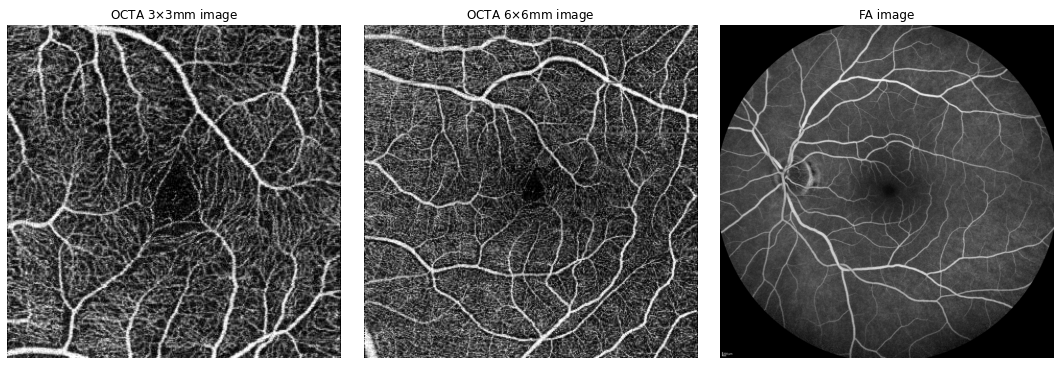

In [3]:
example_case = dataset.get_case("11_INICIAL_SANO")

octa_3x3_image = example_case.load_image("3x3")
octa_6x6_image = example_case.load_image("6x6")
fa_image  = example_case.load_image("AGF")

# Example images
plots.plot_mult(
    [octa_3x3_image, octa_6x6_image, fa_image],
    [r"OCTA 3$\times$3mm image", r"OCTA 6$\times$6mm image", r"FA image"],
    cols=3,
    base_size=5
)

## 1. Introduction: Parameters required

The `registration` package contains a function called `run` to perform the registration process directly. This function only requires to configure two parameters:

- **Scale:** Pre-scaling factor used to convert the OCTA image to the same scale as the angiography image. This factor can be easily determined by the information provided by the devices used to obtain both types of image. In our data set, the scale factor applied along the $𝑥$ and $𝑦$ axes is the same. Specifically, the scale factor for OCTA 3x3mm images is `0.9`, and for OCTA 6x6mm images it is `1.8`.


- **Percentage of blood vessel information:** Estimated approximation of the percentage of image information that represents blood vessels in OCTA images (ratio between pixels of vessels with respect to total pixels). This value is used to facilitate the tuning of the hysteresis filter lower threshold. In this way, the setting of this parameter is done more intuitively than direct tuning of lower threshold. In our dataset, we use `15%` and `30%` for all the 3x3mm and 6x6mm OCTA images, respectively.

This function directly returns the affine transformation matrix necessary to register the OCTA image (previously prescaled).

In [4]:
SCALE = {
    "3x3": 0.9, 
    "6x6": 1.8
}

PERCENTAGE_OF_VESSELS = {
    "3x3": 0.15,  
    "6x6": 0.30
}

## 2. Example using a OCTA 3x3mm image

The OCTA 3x3mm and FA images used in this example are as follows:

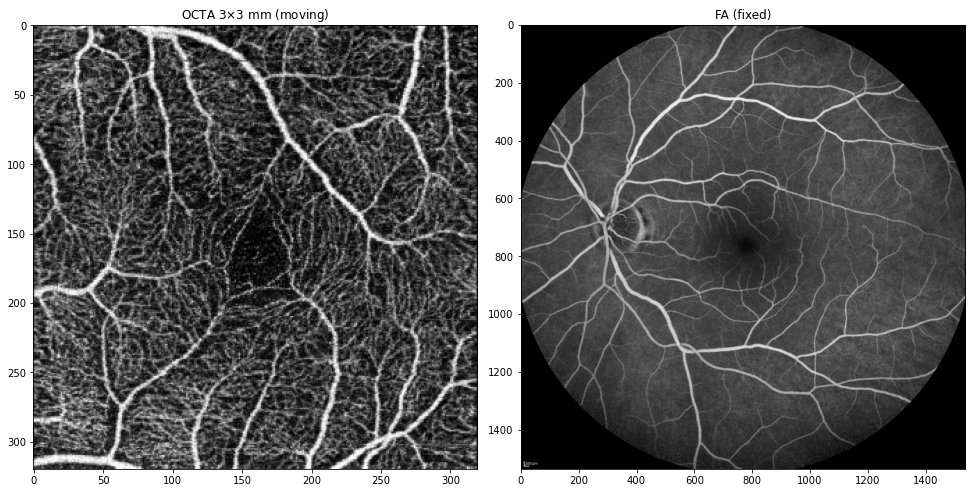

In [5]:
plots.plot_mult(
    [octa_3x3_image, fa_image], 
    [r"OCTA 3$\times$3 mm (moving)", "FA (fixed)"], 
    rows=1, cols=2, base_size=DISPLAY_SIZE, display_axis=True)

Perform the registration process to obtain the Affine transformation matrix.

In [6]:
affine_matrix_3x3 = registration.run(
    fa_image, 
    octa_3x3_image, 
    octa_scale=SCALE['3x3'], 
    info_th=PERCENTAGE_OF_VESSELS['3x3'], 
    verbose=True
)

Resume of process:
 * Template Matching location: (624, 627)
 * Evolutive information: 
     * Fitness value:         0.7247
     * Number of generations: 36 / 150
     * Execution time:        6.78 sec.
 * Total process time: 8.52 sec.
 * Estimated Affine transform: 
       [[  1.04,   0.11, 613.13],
        [ -0.11,   0.99, 635.86],
        [  0.  ,   0.  ,   1.  ]]


Finally, transform the OCTA image (previously pre-scaled) and visualize the final result of the process.

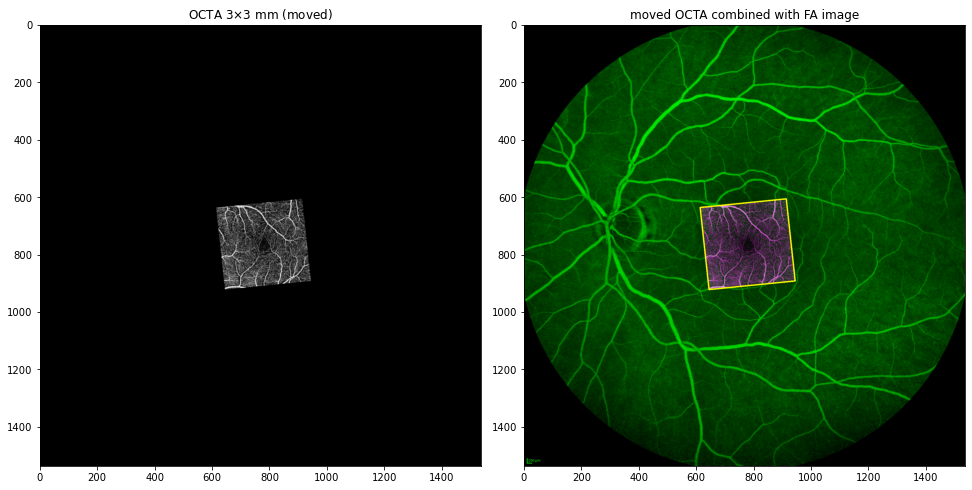

In [7]:
octa_3x3_resized = registration.resize(octa_3x3_image, SCALE['3x3'])

octa_3x3_moved_image = registration.warp_image(octa_3x3_resized, fa_image.shape, affine_matrix_3x3)
combined_3x3_image = registration.warp_and_combine(octa_3x3_resized, fa_image, affine_matrix_3x3)

plots.plot_mult(
    [octa_3x3_moved_image, combined_3x3_image], 
    [r"OCTA 3$\times$3 mm (moved)", r"moved OCTA combined with FA image"], 
    cols=2, base_size=DISPLAY_SIZE,
    display_axis=True)

## 3. Example using a OCTA 6x6mm image

The OCTA 6x6mm and FA images used in this example are as follows:

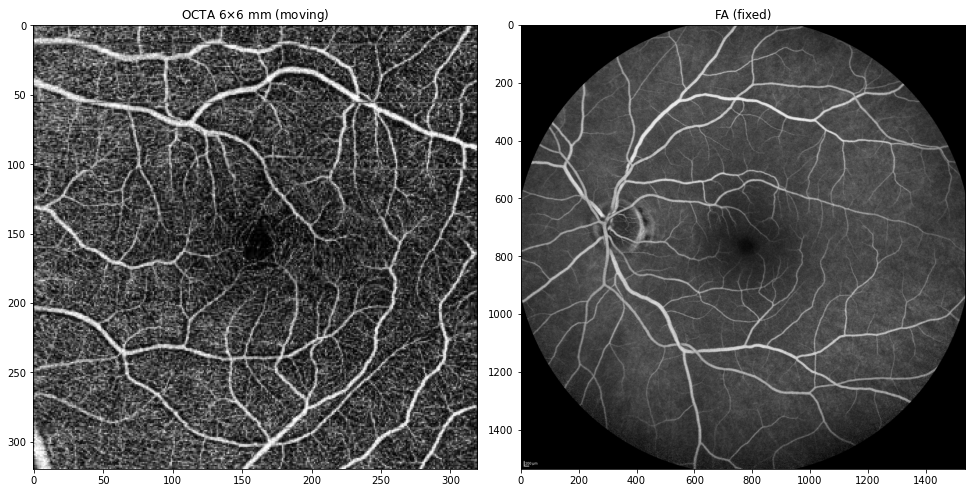

In [8]:
plots.plot_mult(
    [octa_6x6_image, fa_image], 
    [r"OCTA 6$\times$6 mm (moving)", "FA (fixed)"], 
    rows=1, cols=2, base_size=DISPLAY_SIZE, display_axis=True)

Perform the registration process to obtain the Affine transformation matrix.

In [9]:
affine_matrix_6x6 = registration.run(
    fa_image, 
    octa_6x6_image, 
    octa_scale=SCALE['6x6'], 
    info_th=PERCENTAGE_OF_VESSELS['6x6'], 
    verbose=True
)

Resume of process:
 * Template Matching location: (505, 490)
 * Evolutive information: 
     * Fitness value:         0.7527
     * Number of generations: 22 / 150
     * Execution time:        4.73 sec.
 * Total process time: 6.66 sec.
 * Estimated Affine transform: 
       [[  1.03,   0.12, 445.86],
        [ -0.11,   0.99, 519.62],
        [  0.  ,   0.  ,   1.  ]]


Finally, transform the OCTA image (previously pre-scaled) and visualize the final result of the process.

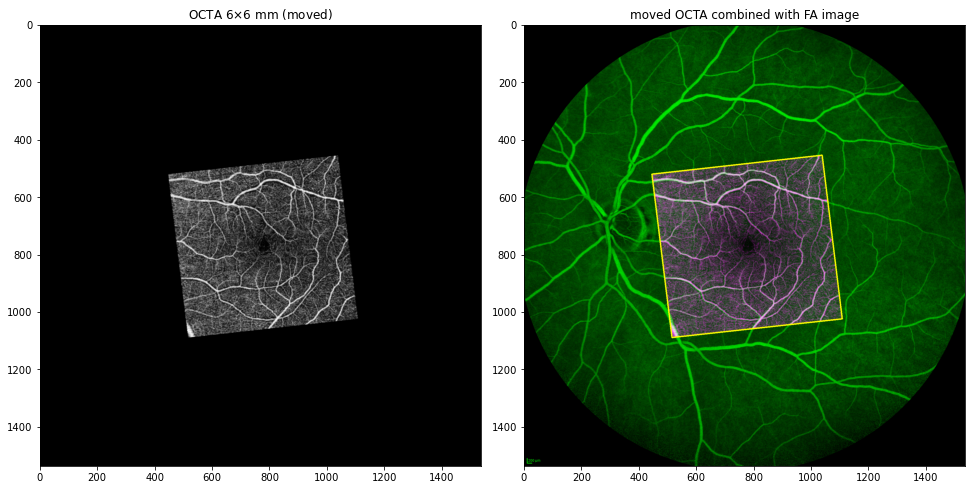

In [10]:
octa_6x6_resized = registration.resize(octa_6x6_image, SCALE['6x6'])

octa_6x6_moved_image = registration.warp_image(octa_6x6_resized, fa_image.shape, affine_matrix_6x6)
combined_6x6_image = registration.warp_and_combine(octa_6x6_resized, fa_image, affine_matrix_6x6)

plots.plot_mult(
    [octa_6x6_moved_image, combined_6x6_image], 
    [r"OCTA 6$\times$6 mm (moved)", r"moved OCTA combined with FA image"], 
    cols=2, base_size=DISPLAY_SIZE,
    display_axis=True)

---
## 4. Speed-up

Moreover, you can reduce the running time of the evolutionary algorithm by using images with the half of its resolution. For this, you only need to enable the optional flag `half_resolution` when calling the main function.

Resume of process:
 * Template Matching location: (505, 490)
 * Evolutive information: 
     * Fitness value:         0.7715
     * Number of generations: 30 / 150
     * Execution time:        1.83 sec.
 * Total process time: 3.47 sec.
 * Estimated Affine transform: 
       [[  1.03,   0.12, 446.26],
        [ -0.11,   0.99, 519.51],
        [  0.  ,   0.  ,   1.  ]]


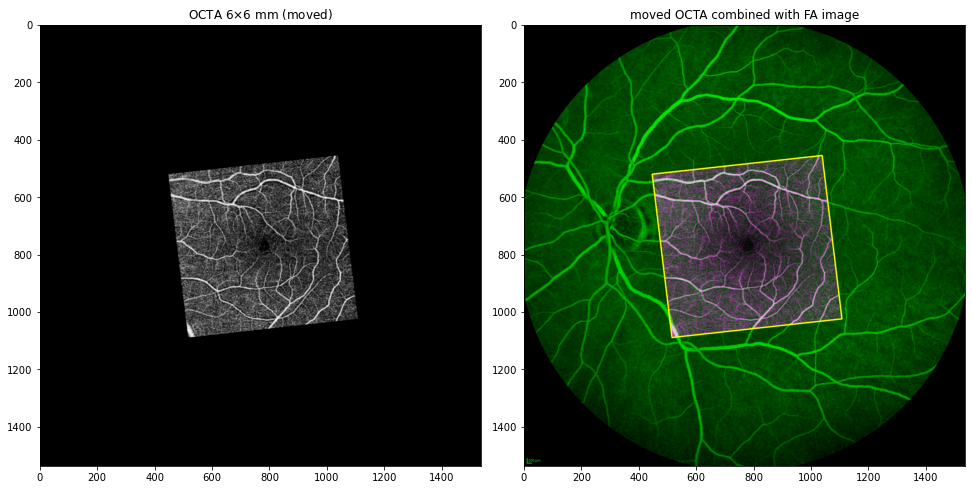

In [11]:
affine_matrix = registration.run(
    fa_image, 
    octa_6x6_image, 
    SCALE['6x6'], 
    PERCENTAGE_OF_VESSELS['6x6'], 
    half_resolution=True,
    verbose=True
)

octa_moved_image = registration.warp_image(octa_6x6_resized, fa_image.shape, affine_matrix)
combined_image = registration.warp_and_combine(octa_6x6_resized, fa_image, affine_matrix)

plots.plot_mult(
    [octa_moved_image, combined_image], 
    [r"OCTA 6$\times$6 mm (moved)", r"moved OCTA combined with FA image"], 
    cols=2, 
    base_size=DISPLAY_SIZE,
    display_axis=True)

As can be seen, performing the process with the images at half resolution, the process takes `3.47` seconds, compared to the `6.66` it took with the original resolution.